In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from datasets import load_dataset
from jaxtyping import Float, Int
from typing import Callable
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import einops as ein

%load_ext autoreload
%autoreload 2

## TODO
- Path patching for hypotheses that paths touching at least one of selected layers are not important
- Path patching for arbitrary sets of paths: maybe learn how to evaluate each path, and then just sum the right subset

## Path patching
![image](img/patching.png)

In [2]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")

layer_list = (
    ["transformer.wte"]
    + [f"transformer.h.{i}" for i in range(8)]
    + ["transformer.lm_head"]
)

### Importance of each layer individually

In [6]:
from utils import random_nested_prompt, path_patching

n = 14
for i in range(len(layer_list)):
    real_prompt = random_nested_prompt(n)
    corrupted_prompt = random_nested_prompt(n)
    res = path_patching(model, tokenizer, real_prompt=real_prompt, corrupted_prompt=corrupted_prompt, steps=[layer_list[i]])
    if res > 0.3:
        print(layer_list[i], res)
real_prompt = random_nested_prompt(n)
corrupted_prompt = random_nested_prompt(n)
res = path_patching(model, tokenizer, real_prompt=real_prompt, corrupted_prompt=corrupted_prompt, steps=[])
print("Total:", res)

transformer.wte 5.552520751953125
transformer.h.0 6.1432318687438965
transformer.h.1 1.4568865299224854
transformer.h.2 1.4492230415344238
transformer.h.6 0.3471503257751465
transformer.h.7 4.20097804069519
transformer.lm_head 5.470365285873413
Total: 6.377852916717529


### Importance of interactions

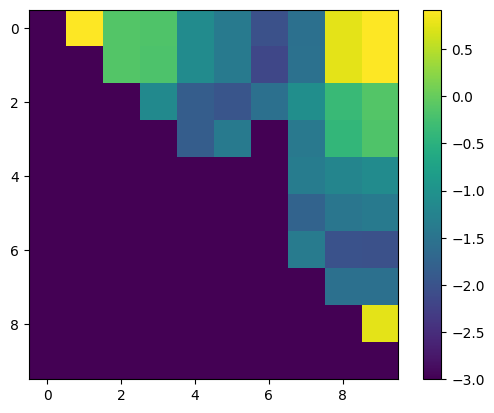

In [13]:
from utils import patch_all_pairs

res = patch_all_pairs(
    model,
    tokenizer,
    "<10 <11 <12 <13 <14 14> 13> 12> 11> 10>",
    "<1 <2 <3 <4 <5 5> 4> 3> 2> 1>",
    layer_list,
)
res = t.triu(res, diagonal=1)
plt.imshow(res.clip(1e-3, 100).log10())
plt.colorbar()
plt.show()

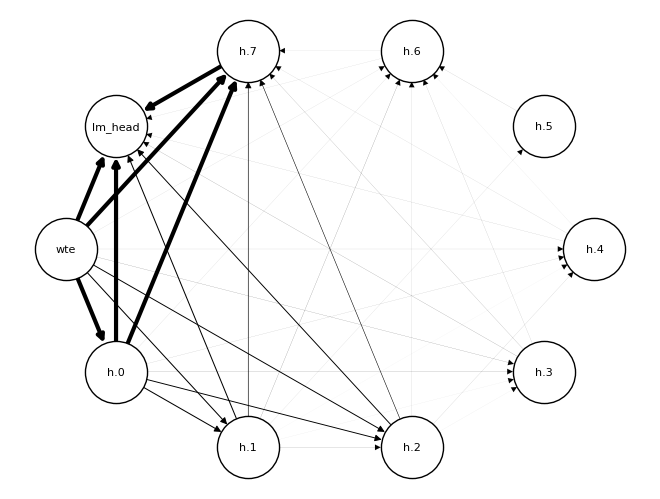

In [36]:
import networkx as nx
from itertools import combinations

G = nx.DiGraph()

short_forms = []
for name in layer_list:
    short_form = ".".join(name.split(".")[1:])
    short_forms.append(short_form)
    G.add_node(short_form)

weights = []
for i, j in combinations(range(10), 2):
    w = min(res[i, j].item(), 3.0)
    if w > 0.01:
        G.add_edge(short_forms[i], short_forms[j])
        weights.append(w)

options = {
    "font_size": 8,
    "node_size": 2000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
}
nx.draw(G, with_labels=True, pos=nx.shell_layout(G), width=weights, **options)

### Replacing layers with $f(x) = x + C$

In [38]:
from sklearn.decomposition import PCA
from utils import get_activations, get_loss, prompt_from_template

layer_deltas = {name: [] for name in layer_list if "h." in name}
for _ in range(100):
    # prompt = prompt_from_template("(())" * 10)
    prompt = prompt_from_template("((((()))))" * 3)
    # prompt = "<5 <6 <7 <8 <9 9> 8> 7> 6> 5>"
    inputs_dict, outputs_dict, _ = get_activations(prompt)
    for name in layer_deltas:
        delta = (outputs_dict[name][0] - inputs_dict[name][0]).squeeze()
        assert_type(
            delta,
            Float[TT, "seq 256"],
        )
        layer_deltas[name].append(delta)
layer_delta = {name: sum(values) / len(values) for name, values in layer_deltas.items()}


class Adder(nn.Module):
    @typed
    def __init__(self, value: Float[TT, "seq 256"]):
        super().__init__()
        self.value = value

    @typed
    def forward(
        self, x: Float[TT, "... seq 256"], *args, **kwargs
    ) -> tuple[Float[TT, "... seq 256"]]:
        return (x + self.value[..., : x.shape[-2], :],)


new_model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
new_model.config.use_cache = False
new_model.config.output_attentions = False
s = 0
for i in [2, 3, 4, 5, 6]:
    s += layer_delta[f"transformer.h.{i}"]
new_model.transformer.h = nn.ModuleList(
    [
        new_model.transformer.h[0],
        new_model.transformer.h[1],
        # new_model.transformer.h[2],
        Adder(s),
        new_model.transformer.h[7],
    ]
)


pca = PCA(n_components=2, whiten=False)
coords = pca.fit_transform(layer_delta["transformer.h.7"])
plt.figure(figsize=(10, 10))
plt.plot(coords[:, 0], coords[:, 1], "-o", lw=1, ms=4)
plt.show()


prompt = prompt_from_template("(())" * 20)
# prompt = prompt_from_template("(())()(())")
# prompt = "<5 <6 <7 <8 <9 9> 8> 7> 6> 5>"
a = get_loss(model, tokenizer, prompt)
b = get_loss(new_model, tokenizer, prompt)
print(f"clean: {a:.3f}, corrupted: {b:.3f}")
print(f"delta: {b - a:.3f}")

ImportError: cannot import name 'get_activations' from 'utils' (/home/mike/Desktop/LanguageTransfer/utils.py)